# **SENTIMENT ANALYSIS - SUPERVISED**

# Inicialització

Inicialitzem els imports necessaris, així com les lectures dels diferents documents i el preprocessament dels texts.

In [19]:
import nltk
import numpy as np
import json
from sklearn.metrics import accuracy_score
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk import pos_tag

In [20]:
import warnings
warnings.filterwarnings("ignore")

In [25]:
# Load datasets
with open('./data/original_data/X_train.json', 'r') as file:
    X_train_data = json.load(file)
    
with open('./data/original_data/X_test.json', 'r') as file:
    X_test_data = json.load(file)

with open('./data/original_data/X_train_no_val.json', 'r') as file:
    X_train_val_data = json.load(file)

with open('./data/original_data/X_val.json', 'r') as file:
    X_val_data = json.load(file)
    
with open('./data/original_data//y_train.json', 'r') as file:
    y_train = json.load(file)
    
with open('./data/original_data/y_test.json', 'r') as file:
    y_test = json.load(file)

with open('./data/original_data/y_train_no_val.json', 'r') as file:
    y_train_val = json.load(file)

with open('./data/original_data/y_val.json', 'r') as file:
    y_val = json.load(file)

In [23]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(min_df=0.0, stop_words='english', strip_accents='ascii')

# Vectorizer alternatiu per comparar resultats amb l'altre
vectorizer_alternate = CountVectorizer(min_df=0.0, binary=True, stop_words='english', strip_accents='ascii')

In [24]:
import string

# Realitzem el preprocessament esmentat: lemmatitzar, treure signes de puntuació i stopwords
wnl = WordNetLemmatizer()
X_train_lem = [" ".join([wnl.lemmatize(i,j[0].lower()) if j[0].lower() in ['a','n','v'] else wnl.lemmatize(i) for i,j in pos_tag(word_tokenize(sent))]) for sent in X_train_data]
X_test_lem = [" ".join([wnl.lemmatize(i,j[0].lower()) if j[0].lower() in ['a','n','v'] else wnl.lemmatize(i) for i,j in pos_tag(word_tokenize(sent))]) for sent in X_test_data]

stop_words = set(nltk.corpus.stopwords.words('english'))
X_train_pre = []
for sent in X_train_lem:
    sentence = []
    for token in word_tokenize(sent):
        if token not in string.punctuation and token not in stop_words and token != "``":
            sentence.append(token)
    X_train_pre.append(" ".join(e for e in sentence))

X_test_pre = []
for sent in X_test_lem:
    sentence = []
    for token in word_tokenize(sent):
        if token not in string.punctuation and token not in stop_words and token not in ["``", "--"]:
            sentence.append(token)
    X_test_pre.append(" ".join(e for e in sentence))

"""
En cas de voler Stemmatitzar:
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()
X_train_stem = [" ".join([stemmer.stem(i) for i in word_tokenize(sent)]) for sent in X_train_data]
X_test_stem = [" ".join([stemmer.stem(i) for i in word_tokenize(sent)]) for sent in X_test_data]
"""


'\nEn cas de voler Stemmatitzar:\nfrom nltk.stem import PorterStemmer\nstemmer = PorterStemmer()\nX_train_stem = [" ".join([stemmer.stem(i) for i in word_tokenize(sent)]) for sent in X_train_data]\nX_test_stem = [" ".join([stemmer.stem(i) for i in word_tokenize(sent)]) for sent in X_test_data]\n'

Realitzem els fits i els transforms tant per les dades que usarem d'entrada ("validació") com per les després usades en train i test. Tenir en compte que aquesta primera validació és tan sols per escollir alguns models que més o menys funcionin, i que la validació real es farà utilitzant Cross-Validation més endavant.

In [26]:
# Dades sense processar, vectorizer normal, de validació
X_train_val = vectorizer.fit_transform(X_train_val_data)
X_val = vectorizer.transform(X_val_data)

# Dades sense processar, vectorizer normal, de train test
X_train = vectorizer.fit_transform(X_train_data)
X_test = vectorizer.transform(X_test_data)

# Dades sense processar, vectorizer alternatiu, de validació
X_train_val_alt = vectorizer_alternate.fit_transform(X_train_val_data)
X_val_alt = vectorizer_alternate.transform(X_val_data)

# Dades sense processar, vectorizer alternatiu, de train test
X_train_alt = vectorizer_alternate.fit_transform(X_train_data)
X_test_alt = vectorizer_alternate.transform(X_test_data)

# Dades lemmatitzades, vectorizer normal, de train test
X_train_lem = vectorizer.fit_transform(X_train_lem)
X_test_lem = vectorizer.transform(X_test_lem)

# Dades amb el preprocessament, vectorizer normal, de train test
X_train_pre = vectorizer.fit_transform(X_train_pre)
X_test_pre = vectorizer.transform(X_test_pre)

"""
X_train_stem = vectorizer.fit_transform(X_train_stem)
X_test_stem = vectorizer.transform(X_test_stem)
"""

'\nX_train_stem = vectorizer.fit_transform(X_train_stem)\nX_test_stem = vectorizer.transform(X_test_stem)\n'

# Models

In [27]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.5, max_depth=3, random_state=0).fit(X_train_val, y_train_val)
clf.score(X_val, y_val)

# 0.7787

0.7786666666666666

In [28]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
clf = AdaBoostClassifier(n_estimators=100, algorithm="SAMME", random_state=0)
clf.fit(X_train_val, y_train_val)

accuracy_score(clf.predict(X_val), y_val)

# 0.808

0.808

In [29]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
clf.fit(X_train_val.toarray(), y_train_val)

accuracy_score(clf.predict(X_val.toarray()), y_val)

# 0.69

0.6906666666666667

In [30]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=800, max_depth=12, random_state=0)
clf.fit(X_train_val, y_train_val)

accuracy_score(clf.predict(X_val), y_val)

# 0.8693

0.8693333333333333

In [31]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0)
clf.fit(X_train_val, y_train_val)

accuracy_score(clf.predict(X_val), y_val)

# 0.8213

0.8213333333333334

In [32]:
from sklearn.svm import SVC
clf = SVC(C=1, kernel='rbf', degree=3)
clf.fit(X_train_val, y_train_val)

accuracy_score(clf.predict(X_val), y_val)

# 0.7813

0.7813333333333333

In [33]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=1)
clf.fit(X_train_val, y_train_val)

accuracy_score(clf.predict(X_val), y_val)

# 0.5413

0.5413333333333333

In [34]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(solver='lbfgs', alpha=1e-3, hidden_layer_sizes=(20, 10), random_state=42)
clf.fit(X_train_val, y_train_val)
accuracy_score(clf.predict(X_val), y_val)

# 0.832

0.832

Observem també, com canvia per exemple el Random Forest i el Logistic Regression amb l'altre vectorizer

In [37]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=800, max_depth=12, random_state=0)
clf.fit(X_train_val_alt, y_train_val)

accuracy_score(clf.predict(X_val_alt), y_val)

# 0.8666

from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0)
clf.fit(X_train_val_alt, y_train_val)

accuracy_score(clf.predict(X_val_alt), y_val)

# 0.856

0.856

# Cross-validation

En aquest apartat, realitzarem una cross-validation per cada model (per escollir els seus millors paràmetres), i després agafarem el millor de tots els models

In [49]:
# Cross-validation

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

# List of models and their hyperparameters
random_state = 0
models_params = [
    (GradientBoostingClassifier(), {'learning_rate': [0.1, 0.25, 0.5], 'max_depth': [3, 6], 'random_state': [random_state]}),
    (AdaBoostClassifier(), {'n_estimators': [50, 100, 200], 'algorithm': ["SAMME", "SAMME.R"], 'learning_rate': [0.5, 1], 'random_state': [random_state]}),
    (RandomForestClassifier(), {'n_estimators': [100, 500, 1000, 1500], 'max_depth': [2, 5, 10, 12, 13, 14, None], 'random_state': [random_state]}),
    (LogisticRegression(), {'max_iter': [1000] , 'random_state': [random_state]}),
    (SVC(), {'C': [0.5, 1, 5], 'kernel': ['linear', 'rbf', 'poly'], 'degree': [1, 2, 3], 'random_state': [random_state]}),
    (MLPClassifier(), {'solver': ['lbfgs', 'adam'], 'learning_rate': ['constant', 'adaptive', 'invscaling'], 'hidden_layer_sizes': [(5, 2), (10, 5), (20, 10)], 'alpha': [1e-2, 1e-3, 1e-5], 'random_state': [random_state]})
]
results = []

def run_grid_search(model, params):
    """
    Runs a grid search for the given model and parameters.
    """
    grid_search = GridSearchCV(model, params, scoring='accuracy', cv=5)
    grid_search.fit(X_train_alt, y_train)
    
    return grid_search.best_params_, grid_search.best_score_

# Run grid search for each model
iter = 1
for model, params in models_params:
    print(f"Running grid search on model: {iter}/{len(models_params)}\r", end="")
    best_params, best_score = run_grid_search(model, params)
    results.append((model.__class__.__name__, best_params, best_score))
    iter += 1

# Show results
for model_name, best_params, best_score in results:
    print(f"{model_name}: Best params = {best_params} (Accuracy = {best_score:.4f})")

best_model = max(results, key=lambda x: x[2])
print(f"BEST MODEL: {best_model[0]} with params = {best_model[1]} (Accuracy = {best_model[2]:.4f})")

GradientBoostingClassifier: Best params = {'learning_rate': 0.25, 'max_depth': 6, 'random_state': 0} (Accuracy = 0.7947)
AdaBoostClassifier: Best params = {'algorithm': 'SAMME', 'learning_rate': 1, 'n_estimators': 200, 'random_state': 0} (Accuracy = 0.7907)
RandomForestClassifier: Best params = {'max_depth': 14, 'n_estimators': 1500, 'random_state': 0} (Accuracy = 0.8613)
LogisticRegression: Best params = {'max_iter': 1000, 'random_state': 0} (Accuracy = 0.8513)
SVC: Best params = {'C': 1, 'degree': 1, 'kernel': 'poly', 'random_state': 0} (Accuracy = 0.8520)
MLPClassifier: Best params = {'alpha': 0.001, 'hidden_layer_sizes': (20, 10), 'learning_rate': 'constant', 'random_state': 0, 'solver': 'lbfgs'} (Accuracy = 0.8593)
BEST MODEL: RandomForestClassifier with params = {'max_depth': 14, 'n_estimators': 1500, 'random_state': 0} (Accuracy = 0.8613)


# Test

Un cop executat el validation, executem el test amb el millor model.

In [66]:
# Run the best model on the test set
best_clf = RandomForestClassifier(max_depth=14, n_estimators=1500, random_state=42)
best_clf.fit(X_train_alt, y_train)
accuracy_score(best_clf.predict(X_test_alt), y_test)

0.854

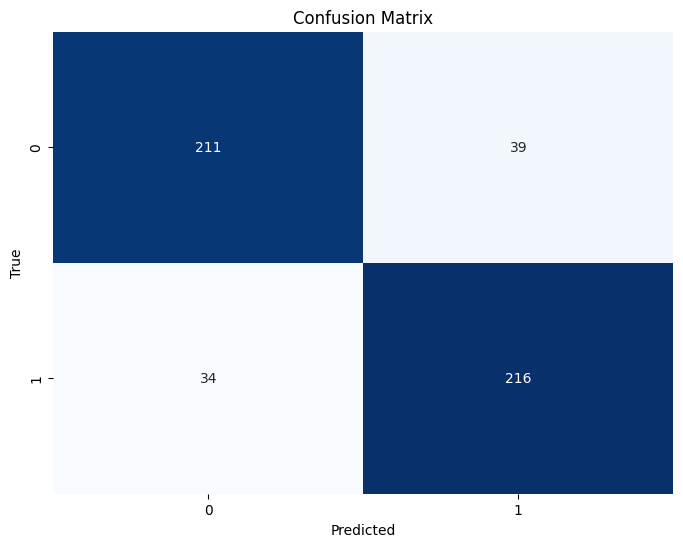

In [67]:
# Create confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = best_clf.predict(X_test_alt)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

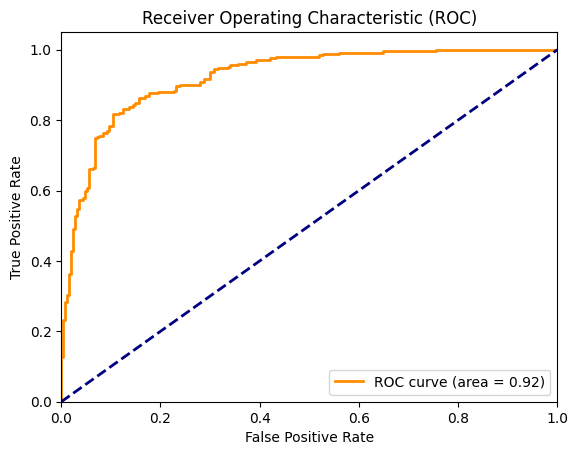

In [68]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_scores = best_clf.predict_proba(X_test_alt)[:, 1]  # Probability estimates

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_scores)

# Calculate the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


Podem observar en quines valoracions d'equivoca:

In [64]:
false_negatives = []
false_positives = []

for i in range(len(y_test)):
    if y_test[i] != y_pred[i]:
        if y_test[i] == 0:  # False Negative
            false_negatives.append(i)
        else:  # False Positive
            false_positives.append(i)

print(X_train_data[false_negatives[0]])

the american action film has been slowly drowning to death in a sea of asian wire - fu copycats . it ' s not a pretty death , and it ' s leaving the likes of schwartznager , stallone , and van damme wearing cement galoshes at the bottom of a kung fu sea . sometimes , the mix results in a mind - blowing spectacle unlike any other . quality action with amazing and exciting stunt work , as in 1999 ' s the matrix , can be a real gem . but too often hollywood gets it wrong , even when they pay off chinese directors . flying ninjas and floating karate masters have been replaced by soaring bronx detectives and slow motion kicking scientists . mostly it ' s laughable . in hollywood ' s rush to emulate the success of the matrix , trademark asian stunt choreography has become more of a joke than an art form . but iron monkey , the latest asian import , shows us how to get it right . iron monkey ( actually a reissue of a 1993 film ) is the story of a 19th chinese vigilante ( rongguang yu ) , figh

També podem veure com rendeixen alguns dels models que haviem "descartat".

In [58]:
clf = MLPClassifier(random_state=42)
clf.fit(X_train_alt, y_train)
accuracy_score(clf.predict(X_test_alt), y_test)

0.856

In [69]:
best_clf = RandomForestClassifier(max_depth=12, n_estimators=1500, random_state=42)
best_clf.fit(X_train, y_train)
accuracy_score(best_clf.predict(X_test), y_test)

0.848

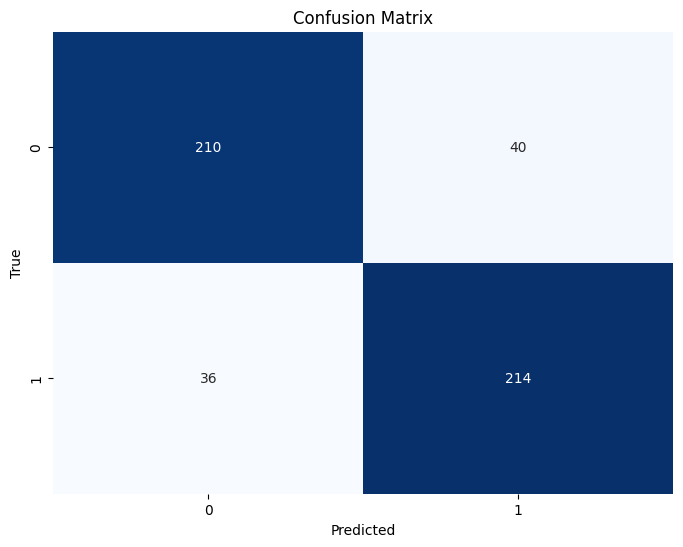

In [70]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = best_clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()